## AI电力能耗预测大赛线性模型实现

## 案例背景介绍

![](https://work.alibaba-inc.com/aliwork_tfs/g01_alibaba-inc_com/tfscom/TB1oAMfQFXXXXX1XVXXXXXXXXXX.tfsprivate.jpg)

案例数据来源于江苏镇江扬中市的高新区企业历史近2年的用电量，希望能够根据历史数据去精准预测未来一个月每一天的用电量，这是一个很典型的时序数据回归类问题，我们来看看如何用数据驱动的建模方法去完成这样一个预测。

In [1]:
from sklearn import preprocessing

In [2]:
help(preprocessing.binarize)

Help on function binarize in module sklearn.preprocessing.data:

binarize(X, threshold=0.0, copy=True)
    Boolean thresholding of array-like or scipy.sparse matrix
    
    Read more in the :ref:`User Guide <preprocessing_binarization>`.
    
    Parameters
    ----------
    X : {array-like, sparse matrix}, shape [n_samples, n_features]
        The data to binarize, element by element.
        scipy.sparse matrices should be in CSR or CSC format to avoid an
        un-necessary copy.
    
    threshold : float, optional (0.0 by default)
        Feature values below or equal to this are replaced by 0, above it by 1.
        Threshold may not be less than 0 for operations on sparse matrices.
    
    copy : boolean, optional, default True
        set to False to perform inplace binarization and avoid a copy
        (if the input is already a numpy array or a scipy.sparse CSR / CSC
        matrix and if axis is 1).
    
    See also
    --------
    Binarizer: Performs binarization usin

### 载入数据

In [3]:
import numpy as np
import pandas as pd

In [4]:
data_1 = pd.read_csv('./input/zhenjiang_power.csv')

In [5]:
data_1.head()

,user_id,record_date,power_consumption
0,1,2015-01-01,1135.0
1,1,2015-01-02,570.0
2,1,2015-01-03,3418.0
3,1,2015-01-04,3968.0
4,1,2015-01-05,3986.0


In [6]:
data_1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 885486 entries, 0 to 885485
Data columns (total 3 columns):
user_id              885486 non-null int64
record_date          885486 non-null object
power_consumption    885486 non-null float64
dtypes: float64(1), int64(1), object(1)
memory usage: 20.3+ MB


In [7]:
data_1.describe()

,user_id,power_consumption
count,885486.000000,8.854860e+05
mean,727.500000,2.619980e+03
std,419.733783,3.154743e+04
min,1.000000,1.000000e+00
25%,364.000000,4.200000e+01
50%,727.500000,2.610000e+02
75%,1091.000000,8.250000e+02
max,1454.000000,1.310016e+06


In [8]:
data_2 = pd.read_csv('./input/zhenjiang_power_9.csv')

In [9]:
data_2.head()

,record_date,user_id,power_consumption
0,2016/9/2,20,1
1,2016/9/3,20,1
2,2016/9/4,20,1
3,2016/9/1,49,1
4,2016/9/2,49,1


In [10]:
train_df = pd.concat([data_1, data_2])

In [11]:
data_1.shape

(885486, 3)

In [12]:
data_2.shape

(43620, 3)

In [13]:
train_df.shape

(929106, 3)

In [14]:
929106 == 43620+885486

True

In [15]:
# 训练数据
train_df.head()

,power_consumption,record_date,user_id
0,1135.0,2015-01-01,1
1,570.0,2015-01-02,1
2,3418.0,2015-01-03,1
3,3968.0,2015-01-04,1
4,3986.0,2015-01-05,1


In [16]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 929106 entries, 0 to 43619
Data columns (total 3 columns):
power_consumption    929106 non-null float64
record_date          929106 non-null object
user_id              929106 non-null int64
dtypes: float64(1), int64(1), object(1)
memory usage: 28.4+ MB


In [17]:
train_df.loc[:,'record_date'] = pd.to_datetime(train_df['record_date'])

In [18]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 929106 entries, 0 to 43619
Data columns (total 3 columns):
power_consumption    929106 non-null float64
record_date          929106 non-null datetime64[ns]
user_id              929106 non-null int64
dtypes: datetime64[ns](1), float64(1), int64(1)
memory usage: 28.4 MB


In [19]:
len(train_df['user_id'].unique())

1454

In [20]:
# 目标：预测未来一个月每一天整个高新区的用电量

In [21]:
train_df = train_df[['record_date', 'power_consumption']].groupby('record_date').agg('sum')

In [22]:
train_df.head()

,power_consumption
record_date,
2015-01-01,2900575.0
2015-01-02,3158211.0
2015-01-03,3596487.0
2015-01-04,3939672.0
2015-01-05,4101790.0


In [23]:
train_df = train_df.reset_index()
train_df.head()

,record_date,power_consumption
0,2015-01-01,2900575.0
1,2015-01-02,3158211.0
2,2015-01-03,3596487.0
3,2015-01-04,3939672.0
4,2015-01-05,4101790.0


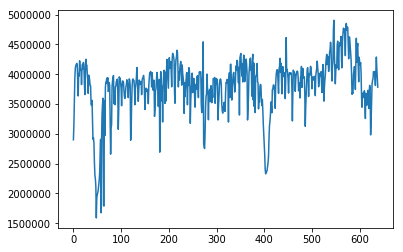

In [24]:
%matplotlib inline
train_df['power_consumption'].plot()

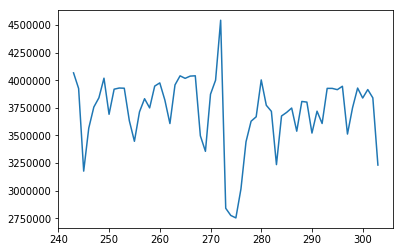

In [25]:
%matplotlib inline
train_df[(train_df['record_date']>='2015-09-01')&(train_df['record_date']<='2015-10-31')]['power_consumption'].plot()

In [26]:
help(pd.DataFrame.set_index)

Help on function set_index in module pandas.core.frame:

set_index(self, keys, drop=True, append=False, inplace=False, verify_integrity=False)
    Set the DataFrame index (row labels) using one or more existing
    columns. By default yields a new object.
    
    Parameters
    ----------
    keys : column label or list of column labels / arrays
    drop : boolean, default True
        Delete columns to be used as the new index
    append : boolean, default False
        Whether to append columns to existing index
    inplace : boolean, default False
        Modify the DataFrame in place (do not create a new object)
    verify_integrity : boolean, default False
        Check the new index for duplicates. Otherwise defer the check until
        necessary. Setting to False will improve the performance of this
        method
    
    Examples
    --------
    >>> df = pd.DataFrame({'month': [1, 4, 7, 10],
    ...                    'year': [2012, 2014, 2013, 2014],
    ...               

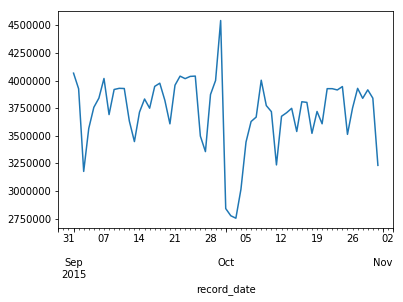

In [27]:
%matplotlib inline
tmp_df = train_df[(train_df['record_date']>='2015-09-01')&(train_df['record_date']<='2015-10-31')].copy()
tmp_df = tmp_df.set_index(['record_date'])
tmp_df['power_consumption'].plot()

### 添加测试数据

In [28]:
train_df.tail()

,record_date,power_consumption
634,2016-09-26,4042132.0
635,2016-09-27,4287965.0
636,2016-09-28,4086998.0
637,2016-09-29,3941842.0
638,2016-09-30,3783264.0


In [29]:
test_df = pd.date_range('2016-10-01', periods=31, freq='D')

In [30]:
test_df = pd.DataFrame(test_df)

In [31]:
test_df.head()

,0
0,2016-10-01
1,2016-10-02
2,2016-10-03
3,2016-10-04
4,2016-10-05


In [32]:
test_df.columns = ['record_date']

In [33]:
test_df.loc[:,'power_consumption'] = 0

In [34]:
test_df.head()

,record_date,power_consumption
0,2016-10-01,0
1,2016-10-02,0
2,2016-10-03,0
3,2016-10-04,0
4,2016-10-05,0


### 拼成一整份数据，做特征工程

In [35]:
total_df = pd.concat([train_df, test_df])

In [36]:
total_df.tail()

,record_date,power_consumption
26,2016-10-27,0.0
27,2016-10-28,0.0
28,2016-10-29,0.0
29,2016-10-30,0.0
30,2016-10-31,0.0


### 构造时间特征

构造一些强时间指代特征：
* 星期几
* 一个月当中的第几天(月初还是月末)
* 一年当中的第几天(季节信息)
* 一年当中的第几个月(季节)、哪一年

In [37]:
tmp = total_df['record_date']

In [38]:
total_df.loc[:,'dow'] = total_df['record_date'].apply(lambda x:x.dayofweek)
total_df.loc[:,'dom'] = total_df['record_date'].apply(lambda x:x.day)
total_df.loc[:,'month'] = total_df['record_date'].apply(lambda x:x.month)
total_df.loc[:,'year'] = total_df['record_date'].apply(lambda x:x.year)

In [39]:
total_df.head()

,record_date,power_consumption,dow,dom,month,year
0,2015-01-01,2900575.0,3,1,1,2015
1,2015-01-02,3158211.0,4,2,1,2015
2,2015-01-03,3596487.0,5,3,1,2015
3,2015-01-04,3939672.0,6,4,1,2015
4,2015-01-05,4101790.0,0,5,1,2015


#### 添加周末特征

In [40]:
total_df.loc[:,'weekend'] = 0
total_df.loc[:,'weekend_sat'] = 0
total_df.loc[:,'weekend_sun'] = 0

In [41]:
total_df.head()

,record_date,power_consumption,dow,dom,month,year,weekend,weekend_sat,weekend_sun
0,2015-01-01,2900575.0,3,1,1,2015,0,0,0
1,2015-01-02,3158211.0,4,2,1,2015,0,0,0
2,2015-01-03,3596487.0,5,3,1,2015,0,0,0
3,2015-01-04,3939672.0,6,4,1,2015,0,0,0
4,2015-01-05,4101790.0,0,5,1,2015,0,0,0


In [42]:
total_df.loc[(total_df['dow']>4),'weekend'] = 1

In [43]:
total_df.loc[(total_df['dow']==5),'weekend_sat'] = 1
total_df.loc[(total_df['dow']==6),'weekend_sun'] = 1

#### 添加一个月4周的信息

In [44]:
def week_of_month(day):
    if day in range(1,8):
        return 1
    if day in range(8,15):
        return 2
    if day in range(15,22):
        return 3
    else:
        return 4
total_df.loc[:,'week_of_month'] = total_df['dom'].apply(lambda x:week_of_month(x))

In [45]:
total_df.head()

,record_date,power_consumption,dow,dom,month,year,weekend,weekend_sat,weekend_sun,week_of_month
0,2015-01-01,2900575.0,3,1,1,2015,0,0,0,1
1,2015-01-02,3158211.0,4,2,1,2015,0,0,0,1
2,2015-01-03,3596487.0,5,3,1,2015,1,1,0,1
3,2015-01-04,3939672.0,6,4,1,2015,1,0,1,1
4,2015-01-05,4101790.0,0,5,1,2015,0,0,0,1


#### 添加上中下旬

In [46]:
def period_of_month(day):
    if day in range(1,11):
        return 1
    if day in range(11,21):
        return 2
    else:
        return 3
total_df.loc[:,'period_of_month'] = total_df['dom'].apply(lambda x:period_of_month(x))

#### 添加上半月和下半月

In [47]:
def period2_of_month(day):
    if day in range(1,16):
        return 1
    else:
        return 2
total_df.loc[:,'period2_of_month'] = total_df['dom'].apply(lambda x:period2_of_month(x))

In [48]:
total_df.head()

,record_date,power_consumption,dow,dom,month,year,weekend,weekend_sat,weekend_sun,week_of_month,period_of_month,period2_of_month
0,2015-01-01,2900575.0,3,1,1,2015,0,0,0,1,1,1
1,2015-01-02,3158211.0,4,2,1,2015,0,0,0,1,1,1
2,2015-01-03,3596487.0,5,3,1,2015,1,1,0,1,1,1
3,2015-01-04,3939672.0,6,4,1,2015,1,0,1,1,1,1
4,2015-01-05,4101790.0,0,5,1,2015,0,0,0,1,1,1


#### 填充法定节假日

In [49]:
total_df.loc[:,'festival'] = 0

In [50]:
total_df.loc[(total_df.month==10)&(total_df.dom<8), 'festival']=1

In [51]:
total_df.head()

,record_date,power_consumption,dow,dom,month,year,weekend,weekend_sat,weekend_sun,week_of_month,period_of_month,period2_of_month,festival
0,2015-01-01,2900575.0,3,1,1,2015,0,0,0,1,1,1,0
1,2015-01-02,3158211.0,4,2,1,2015,0,0,0,1,1,1,0
2,2015-01-03,3596487.0,5,3,1,2015,1,1,0,1,1,1,0
3,2015-01-04,3939672.0,6,4,1,2015,1,0,1,1,1,1,0
4,2015-01-05,4101790.0,0,5,1,2015,0,0,0,1,1,1,0


In [52]:
total_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 670 entries, 0 to 30
Data columns (total 13 columns):
record_date          670 non-null datetime64[ns]
power_consumption    670 non-null float64
dow                  670 non-null int64
dom                  670 non-null int64
month                670 non-null int64
year                 670 non-null int64
weekend              670 non-null int64
weekend_sat          670 non-null int64
weekend_sun          670 non-null int64
week_of_month        670 non-null int64
period_of_month      670 non-null int64
period2_of_month     670 non-null int64
festival             670 non-null int64
dtypes: datetime64[ns](1), float64(1), int64(11)
memory usage: 73.3 KB


线性模型：WX+b

#### 独热向量编码

In [53]:
total_df.columns

Index(['record_date', 'power_consumption', 'dow', 'dom', 'month', 'year',
       'weekend', 'weekend_sat', 'weekend_sun', 'week_of_month',
       'period_of_month', 'period2_of_month', 'festival'],
      dtype='object')

In [54]:
var_to_encoding = [u'dow', u'dom', u'month', u'year',u'week_of_month', u'period_of_month',  u'period2_of_month']

In [55]:
dummy_df = pd.get_dummies(total_df, columns=var_to_encoding)

In [56]:
dummy_df.head()

,record_date,power_consumption,weekend,weekend_sat,weekend_sun,festival,dow_0,dow_1,dow_2,dow_3,...,year_2016,week_of_month_1,week_of_month_2,week_of_month_3,week_of_month_4,period_of_month_1,period_of_month_2,period_of_month_3,period2_of_month_1,period2_of_month_2
0,2015-01-01,2900575.0,0,0,0,0,0,0,0,1,...,0,1,0,0,0,1,0,0,1,0
1,2015-01-02,3158211.0,0,0,0,0,0,0,0,0,...,0,1,0,0,0,1,0,0,1,0
2,2015-01-03,3596487.0,1,1,0,0,0,0,0,0,...,0,1,0,0,0,1,0,0,1,0
3,2015-01-04,3939672.0,1,0,1,0,0,0,0,0,...,0,1,0,0,0,1,0,0,1,0
4,2015-01-05,4101790.0,0,0,0,0,1,0,0,0,...,0,1,0,0,0,1,0,0,1,0


In [57]:
dummy_df.columns

Index(['record_date', 'power_consumption', 'weekend', 'weekend_sat',
       'weekend_sun', 'festival', 'dow_0', 'dow_1', 'dow_2', 'dow_3', 'dow_4',
       'dow_5', 'dow_6', 'dom_1', 'dom_2', 'dom_3', 'dom_4', 'dom_5', 'dom_6',
       'dom_7', 'dom_8', 'dom_9', 'dom_10', 'dom_11', 'dom_12', 'dom_13',
       'dom_14', 'dom_15', 'dom_16', 'dom_17', 'dom_18', 'dom_19', 'dom_20',
       'dom_21', 'dom_22', 'dom_23', 'dom_24', 'dom_25', 'dom_26', 'dom_27',
       'dom_28', 'dom_29', 'dom_30', 'dom_31', 'month_1', 'month_2', 'month_3',
       'month_4', 'month_5', 'month_6', 'month_7', 'month_8', 'month_9',
       'month_10', 'month_11', 'month_12', 'year_2015', 'year_2016',
       'week_of_month_1', 'week_of_month_2', 'week_of_month_3',
       'week_of_month_4', 'period_of_month_1', 'period_of_month_2',
       'period_of_month_3', 'period2_of_month_1', 'period2_of_month_2'],
      dtype='object')

### 分离训练集和测试集

In [58]:
train_X = dummy_df[dummy_df.record_date<'2016-10-01']
train_y = dummy_df[dummy_df.record_date<'2016-10-01']['power_consumption']
test_X = dummy_df[dummy_df.record_date>='2016-10-01']

In [59]:
train_X.head()

,record_date,power_consumption,weekend,weekend_sat,weekend_sun,festival,dow_0,dow_1,dow_2,dow_3,...,year_2016,week_of_month_1,week_of_month_2,week_of_month_3,week_of_month_4,period_of_month_1,period_of_month_2,period_of_month_3,period2_of_month_1,period2_of_month_2
0,2015-01-01,2900575.0,0,0,0,0,0,0,0,1,...,0,1,0,0,0,1,0,0,1,0
1,2015-01-02,3158211.0,0,0,0,0,0,0,0,0,...,0,1,0,0,0,1,0,0,1,0
2,2015-01-03,3596487.0,1,1,0,0,0,0,0,0,...,0,1,0,0,0,1,0,0,1,0
3,2015-01-04,3939672.0,1,0,1,0,0,0,0,0,...,0,1,0,0,0,1,0,0,1,0
4,2015-01-05,4101790.0,0,0,0,0,1,0,0,0,...,0,1,0,0,0,1,0,0,1,0


In [60]:
drop_columns = ['record_date','power_consumption']
train_X = train_X.drop(drop_columns, axis=1)
test_X = test_X.drop(drop_columns, axis=1)

In [61]:
train_X.columns

Index(['weekend', 'weekend_sat', 'weekend_sun', 'festival', 'dow_0', 'dow_1',
       'dow_2', 'dow_3', 'dow_4', 'dow_5', 'dow_6', 'dom_1', 'dom_2', 'dom_3',
       'dom_4', 'dom_5', 'dom_6', 'dom_7', 'dom_8', 'dom_9', 'dom_10',
       'dom_11', 'dom_12', 'dom_13', 'dom_14', 'dom_15', 'dom_16', 'dom_17',
       'dom_18', 'dom_19', 'dom_20', 'dom_21', 'dom_22', 'dom_23', 'dom_24',
       'dom_25', 'dom_26', 'dom_27', 'dom_28', 'dom_29', 'dom_30', 'dom_31',
       'month_1', 'month_2', 'month_3', 'month_4', 'month_5', 'month_6',
       'month_7', 'month_8', 'month_9', 'month_10', 'month_11', 'month_12',
       'year_2015', 'year_2016', 'week_of_month_1', 'week_of_month_2',
       'week_of_month_3', 'week_of_month_4', 'period_of_month_1',
       'period_of_month_2', 'period_of_month_3', 'period2_of_month_1',
       'period2_of_month_2'],
      dtype='object')

### 线性模型建模

In [62]:
from sklearn.linear_model import RidgeCV

In [63]:
linear_reg = RidgeCV(alphas=[0.2,0.5,0.8], cv=5)

In [64]:
linear_reg.fit(train_X,train_y)

RidgeCV(alphas=[0.2, 0.5, 0.8], cv=5, fit_intercept=True, gcv_mode=None,
    normalize=False, scoring=None, store_cv_values=False)

In [65]:
linear_reg.score(train_X, train_y)

0.5374040636634445

### 进行结果预测

In [66]:
predictions = linear_reg.predict(test_X)

In [67]:
predictions

array([3212925.95472827, 3123665.81601722, 3487690.48833757,
       3548856.93167408, 3482587.25039117, 3525718.30745999,
       3553050.77962209, 3821118.66870908, 3646062.63550261,
       3918518.56929085, 3962237.29742303, 3992247.34091076,
       3970024.36128233, 3962719.28757287, 3771784.99825845,
       3656844.18822509, 3948231.95687571, 4010857.98736819,
       4015766.81525959, 3916446.33563116, 3946721.15642422,
       3893335.69557761, 3768137.04769225, 4045312.20166398,
       4074657.31472527, 4073132.15179098, 4073516.37399741,
       3952440.06175584, 3955847.60387611, 3732770.75298771,
       3912423.13089389])

In [68]:
test_df.head()

,record_date,power_consumption
0,2016-10-01,0
1,2016-10-02,0
2,2016-10-03,0
3,2016-10-04,0
4,2016-10-05,0


In [69]:
test_df.loc[:,'power_consumption'] = predictions

In [70]:
test_df.head()

,record_date,power_consumption
0,2016-10-01,3.212926e+06
1,2016-10-02,3.123666e+06
2,2016-10-03,3.487690e+06
3,2016-10-04,3.548857e+06
4,2016-10-05,3.482587e+06


In [71]:
test_df.to_csv('linear_reg.csv', index=None)

In [72]:
pred = linear_reg.predict(train_X)

In [88]:
### 标准化
data = train_df['power_consumption'].values.astype('float32')
max_value = np.max(data)
min_value = np.min(data)
scalar = max_value - min_value

In [89]:
train_y = list(map(lambda x: x / scalar, train_y))

In [91]:
pred = list(map(lambda x: x / scalar, pred))

In [94]:
mean_squar_error = np.mean((np.array(train_y) - np.array(pred))**2)

In [96]:
import matplotlib.pyplot as plt

Text(0.5,1,'Liear Regression - MSE:0.00948')

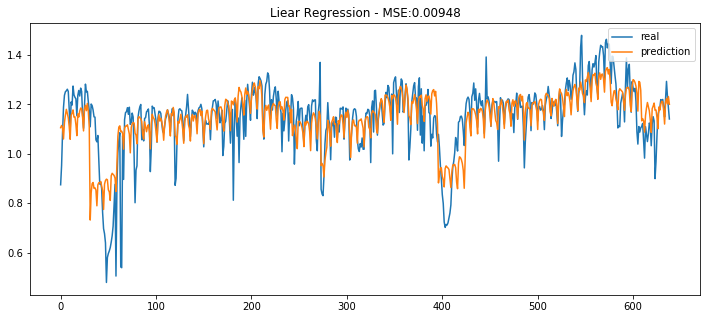

In [98]:
plt.figure(figsize=(12,5))
plt.title('Liear Regression - MSE:{:.5f}'.format(mean_squar_error))
plt.plot(train_y,label = 'real')
plt.plot(pred,label = 'prediction')
plt.legend(loc = 'upper right')